# UCN LD2 Calculations: Condensation

K. Augusto, J. Martin

August 10/20

Calculates the performance of a straight, multi-finned HEX  at the saturation point of liquid deuterium.

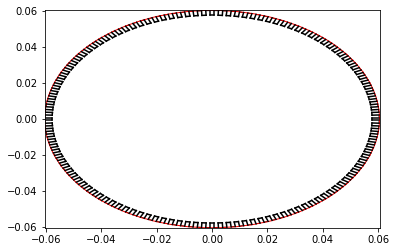

In [129]:
from math import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import interpolate
from scipy.integrate import odeint
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
fluid='Deuterium'

##############################################################
#General Constants Used
#############################################################
g=9.8 #m/s
p_psi16=16. # PSI, from CM.LD2.015.R2
p16=p_psi16*6894.76 # Pa
mu=3.5e-5 #Pa*s from https://nvlpubs.nist.gov/nistpubs/Legacy/TN/nbstechnicalnote641.pdf
kt=0.104 #W/m*K from https://nvlpubs.nist.gov/nistpubs/Legacy/TN/nbstechnicalnote641.pdf
beta_t=.012 # K^(-1), relative slope of density with temperature (a la Boussinesq)
cp=6565. # J/kg*K (for liquid D2), from CoolProp
Tw=19.8 #K, from CM.LD2.015.R2
rho=163 #kg/m3, from CRYOGENIC DATA BOOK by Dudley B. Chelton and Douglas B. Mann, pg 22
##############################################################
#Geometry of HEX
#############################################################
d2=4.76*0.0254 # (m) inner diameter of the outer tubular housing, from CM.LD2.015.R2
d1=4.75*0.0254 # (m) diameter of the inner cold cylinder before cutting any grooves, from CM.LD2.015.R2
fig,ax=plt.subplots()
ax.set_xlim([-d2/2,d2/2])
ax.set_ylim([-d2/2,d2/2])
# outer housing
circle1=plt.Circle((0,0),d2/2,color='r',fill=False)
ax.add_artist(circle1)
groove_depth=0.1*0.0254 # m
groove_width=0.06*0.0254 # m
n=ngrooves=124
# shorter names
r=d1/2
w=groove_width
d=groove_depth
for groove in range(ngrooves):
    theta=360./ngrooves
    center_angle=groove*theta
    alpha=center_angle*pi/180
    x=r*cos(alpha)
    y=r*sin(alpha)
    dalpha=asin(w/2/r)
    xsl=r*cos(alpha+dalpha)
    ysl=r*sin(alpha+dalpha)
    xel=xsl-d*cos(alpha)
    yel=ysl-d*sin(alpha)
    xsr=r*cos(alpha-dalpha)
    ysr=r*sin(alpha-dalpha)
    xer=xsr-d*cos(alpha)
    yer=ysr-d*sin(alpha)
    # draw line at edge of each groove
    line=plt.plot([xsl,xel],[ysl,yel],color='black')
    line=plt.plot([xsr,xer],[ysr,yer],color='black')
    # and bottom of groove
    line=plt.plot([xel,xer],[yel,yer],color='black')
    alpha_deg=alpha*180/pi
    dalpha_deg=dalpha*180/pi
    arc=patches.Arc((0,0),2*r,2*r,0,alpha_deg+dalpha_deg,alpha_deg+theta-dalpha_deg)
    ax.add_patch(arc)
# Calculation of perimeter of all those grooves
pgroove=2*d+w # inner "U" of a groove
parc=(theta-2*dalpha_deg)*pi/180*r # outer arc length between two grooves
perimeter=ngrooves*(pgroove+parc)
# Calculation of area for flow
annulus=pi*(d2**2-d1**2)/4
agroove=d*w # area of one groove # approximately
aeps=((2*dalpha)/(2*pi))*pi*r**2-2*0.5*(w/2)*(r*cos(dalpha)) # area between the arc
                                                             # and the area of the
                                                             # groove on the previous line
agroove_total=agroove+aeps #m^2, total area of one groove
agrooves=agroove_total*ngrooves #m^2, total area of the grooves
area=annulus+agrooves #m^2, total area of the HEX where fluid will flow
plt.show()
a=area # (m^2) area for fluid flow
p=perimeter+pi*d2 # (m) perimeter of flow region
dh=4*a/p # (m) hydraulic diameter
L=10*0.0254 #m, from CM.LD2.015.R2
Aw = perimeter*L #m^2, the area of the cold walls

This system is a large tank containing deuterium gas connected to the thermosyphon loop where liquid deterium will be flowing. Mass will have to be conserved throughout the system, then

\begin{equation}
m = \rho(T_{293},P_{150psia})(V_{tank}+V_{loop}) = \rho(T_{20},P_{16psia})V_{loop} + \rho(T_{293},P_{16psia})V_{tank}
\end{equation}

To find the volume of the large tank, 

\begin{equation}
V_{tank} = \frac{V_{loop}(\rho(T_{20},P_{16psia})-\rho(T_{293},P_{150psia}))}{\rho(T_{293},P_{150psia})-\rho(T_{293},P_{16psia})}
\end{equation}

In [130]:
Plow=16*6894.76 # Pa
Phigh=150*6894.76 # Pa
total_mass=rho_293*(Vtank+Vts) # kg, total mass of deuterium
rho_cold=PropsSI('D','T',20,'P',(16*6894.76),fluid) #kg/m^3, density of LD2 when it is at 20 K and 16 PSIA
rho_cold293=PropsSI('D','T',293,'P',(16*6894.76),fluid) #kg/m^3, density of LD2 when it is at 293 K (coming from the large tank back into the loop - about to condense) at 16 PSIA
#print(rho_cold)
rho_293=PropsSI('D','T',293,'P',(150*6894.76),fluid) #kg/m^3, density of deuterium gas at 293 K at 150 PSIA (in the large tank)
#print(rho_293)
Vts=0.102318 #m^3, volume of the thermosyphon loop
Vtank = (Vts*(rho_cold-rho_293))*(1/(rho_293-rho_cold293)) #m^3, volume of the large tank of gas
print('The Volume of the large tank is %f m^3.' %Vtank)

The Volume of the large tank is 11.467568 m^3.


The saturation curve for liquid deuterium is plotted below, from about 14 PSIA to about 200 PSIA. 

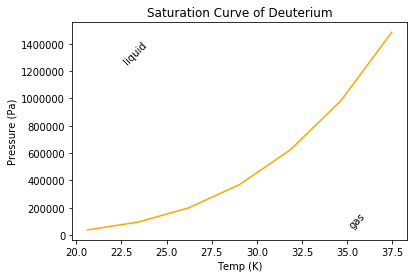

In [131]:
Ts = np.linspace(15, 293, 100)
ps = PropsSI('P','T',Ts,'Q',0,'Deuterium')
plt.plot(Ts,ps,'orange')
plt.title('Saturation Curve of Deuterium')
plt.ylabel('Pressure (Pa)')
plt.xlabel('Temp (K)')
plt.text(22.5, 1.25e6, 'liquid', rotation = 45)
plt.text(35, 5e4, 'gas', rotation = 45)
plt.show()

At the point of saturation, the pressures between the loop and tank will be in equilibrium. Then, to solve for the pressure at saturated conditions, the equilibrium pressure was found. 

\begin{equation}
P_{sat}(T_{cold}) = P\bigg(T_{tank},\rho_{tank}=\frac{m-\rho_{sat}(T_{cold})V_{loop}}{V_{tank}}\bigg)
\end{equation}



In [133]:
for P in np.linspace(Plow,Phigh,1000):
    rho_sat_V=PropsSI('D','P',P,'Q',1,fluid)
    Ptank=PropsSI('P','T',293,'D',(total_mass-rho_sat_V*Vts)/Vtank,fluid)
    #print(P,rho_sat_V,Ptank)
    if(P>Ptank):
        break
print('The saturated pressure is %f Pa, %f PSIA' %(Ptank,Ptank/6894.76))
Tcold=PropsSI('T','P',Ptank,'Q',1,fluid)
print('The temperature at the saturated pressure is %f K.' %Tcold) 
rho_sat_V=PropsSI('D','P',P,'Q',1,fluid)
Tcoldprime=PropsSI('T','P',Ptank,'D',rho_sat_V,fluid)
#print(Tcoldprime)
p=933308.3953815895

The saturated pressure is 933308.395382 Pa, 135.364885 PSIA
The temperature at the saturated pressure is 34.313212 K.


The saturated pressure is then 933308 Pa, or 135.4 PSIA. Vapour will start to condense at 34 K at that pressure. Using the saturation pressure found, the enthalpy of vapourization and enthalpy of the liquid was found using CoolProp. To calculate the heat transfer coefficient of the condensate, the Reynolds number and Nusselt number must be found from the condensate correlation numbers. Following Example 7.11 from Barron, the latent heat of vapourization, $i_{fg}$, found from the difference between the vapour and liquid enthalpies is:

\begin{equation}
i_{fg} = H_V- H_L
\end{equation}

In [ ]:
Tsat=CP.PropsSI('T','P',p,'Q',1,fluid) #from cool prop
print()
print('The temperature at saturated pressure, %f PSIA, is %f K' %(p/6895,Tsat))

HV=CP.PropsSI('H','P',p,'Q',1,fluid) #J, enthalpy of vapourizatin

HL=CP.PropsSI('H','P',p,'Q',0,fluid) #J, enthalpy of the liquid

ifg = HV - HL #J/kg also from cool prop heat(enthalpy)
rho_v=CP.PropsSI('D','T',Tsat,'Q',1,fluid) #kg/m3, density of the deuterium vapour at the saturated temperature above

The "effective" heat of vapourization takes into account, approximately, the subcooling in the condsate layer. From Equation 7.79 in Barron, 

\begin{equation}
i_{fg,e} = i_{fg} + 0.68C_p(T_{sat}-T_w)
\end{equation}


The Prandtl number from Equation 6.14 of Barron,

\begin{equation}
Pr = \frac{\mu C_p}{kt}
\end{equation}

The Jakob number from Equation 7.84 of Barron is

\begin{equation}
Ja = \frac{C_p(T_{sat}-T_w}{ifg_e}
\end{equation}

The "condensation" Rayleigh number is defind by Equation 7.83 in Barron,

\begin{equation}
Ra = \frac{g\rho(\rho-\rho_v)L^3Pr}{\mu^2}
\end{equation}

In [ ]:
ifge= ifg + 0.68*cp*(Tsat-Tw) #Eq'n 7.79 Barron

Pr=(mu*cp)/(kt) # Eq'n 6.14 Barron

#jakob number

Ja = (cp*(Tsat-Tw))/ifge # Eq'n 7.84 Barron

#Rayleigh number

Ra = (g*rho*(rho-rho_v)*L**3*Pr)/(mu**2) #Eq'n 7.83 Barron


Assuming the condensate flow is laminar, the Nusselt number can be found from Equation 7.89 in Barron,

\begin{equation}
Nu = 0.9428\bigg(\frac{Ra}{Ja}\bigg)^{1/4}
\end{equation}

The Reynold number of the condensate film from Equaton 7.93 in Barron is

\begin{equation}
Re = \frac{4NuJa}{Pr}
\end{equation}

In [ ]:
Nu=0.9428*(Ra/Ja)**(1/4) #Eq'n 7.89 Barron

#assuming laminar correlation

Re = (4*Nu*Ja)/Pr #Eq'n 7.93 in Barron

print('The Reynolds number is %f' %Re)


The condensate Grashof number from Equation 7.95 is

\begin{equation}
Gr = \frac{g\rho(\rho-\rho_v)L^3}{\mu^2}
\end{equation}

As the Reynolds number is 1256, that indicates that the flow is in the laminar-wavy range (30 < Re < 1800). Then, the average Nusselt number for this region can be written as

\begin{equation}
Nu = \bigg(\frac{Pr}{4Ja}\bigg) \bigg(\frac{Gr^{1/3}Ja}{(0.27Pr +4.815)^{1/1.22}}\bigg)
\end{equation}

from Equation 7.96 in Barron.

In [ ]:
Gr = (g*rho*(rho-rho_v)*L**3)/(mu**2) #Eq'n 7.95 Barron
Nu2 = ((Pr) / (4*Ja))*(((Gr**(1/3)*Ja) / (0.27*Pr)) + 4.815)**(1/1.22) #Eq'n 7.96 Barron

The Reynolds number can be found again using the average Nusselt number found above. From Equaton 7.93 in Barron again,

\begin{equation}
Re = \frac{4NuJa}{Pr}
\end{equation}

In [ ]:
Re2 = (4*Nu2*Ja)/Pr #Eq'n 7.93 in Barron

print('The Reynolds number is %f' %Re2)

The Reynolds number is still in the laminar-wavy range. The heat transfer coefficient from Equation 7.96 in Barron is

\begin{equation}
hc = \frac{Nukt}{L}
\end{equation}

In [ ]:
hc = Nu2*kt/L #Eq'n 7.96 Barron

print('heat coeff is %f W/m2K' %hc)

The convection rate from Equation 6.43 in Barron is

\begin{equation}
\dot{Q} = hcA_w(T_{sat}-T_w)
\end{equation}

In [ ]:
Qdot = hc*Aw*(Tsat-Tw) #Eq'n 6.43 Barron
print('convection rate %f W' %Qdot)

Finally, the mass flux from Equation 7.78 in Barron is

\begin{equation}
\dot{m} = \frac{\dot{Q}}{ifg_e}
\end{equation}

In [ ]:
mdot = Qdot/ifge #Eq'n 7.78 Barron
print('mass flux is %f kg/s'%mdot)

When the system is cold and full of deuterium, the saturated conditions will be at 16 PSIA. Then, the large tank will also have a pressure of 16 psia of deuterium at room temperature. The system could be regulated to stay at 16 PSIA. The previous calculations were carried out taking the saturation pressure to be 16 PSIA instead of about 135 PSIA.  

Using 16 PSIA, the enthalpies were found using CoolProp. Then, the latent heat of vapourization, $i_{fg}$, found from the difference between the vapour and liquid enthalpies is:

\begin{equation}
i_{fg} = H_V- H_L
\end{equation}

In [ ]:
Tsat16=CP.PropsSI('T','P',p16,'Q',1,fluid) #K, from cool prop
HV16=CP.PropsSI('H','P',p16,'Q',1,fluid) #J/kg, from cool prop
HL16=CP.PropsSI('H','P',p16,'Q',0,fluid) #J/kg, from cool prop
ifg16 = HV16 - HL16 #J/kg, from cool prop heat(enthalpy)
Tw=19.8
rho=168 #kg/m3
rho_v16=CP.PropsSI('D','T',Tsat16,'Q',1,fluid) #kg/m3

The "effective" heat of vapourization takes into account, approximately, the subcooling in the condsate layer. From Equation 7.79 in Barron, 

\begin{equation}
i_{fg,e} = i_{fg} + 0.68C_p(T_{sat}-T_w)
\end{equation}


In [ ]:
ifge16= ifg16 + 0.68*cp*(Tsat16-Tw) #Eq'n 7.79 Barron

The Prandtl number from Equation 6.14 of Barron,

\begin{equation}
Pr = \frac{\mu C_p}{kt}
\end{equation}

In [ ]:
Pr=(mu*cp)/(kt) #Eq'n 6.14 Barron

The Jakob number from Equation 7.84 of Barron is

\begin{equation}
Ja = \frac{C_p(T_{sat}-T_w}{ifg_e}
\end{equation}

In [ ]:
Ja16 = (cp*(Tsat16-Tw))/ifge16 #Eq'n 7.84 Barron

The "condensation" Rayleigh number is defind by Equation 7.83 in Barron,

\begin{equation}
Ra = \frac{g\rho(\rho-\rho_v)L^3Pr}{\mu^2}
\end{equation}

In [ ]:
Ra16 = (g*rho*(rho-rho_v16)*L**3*Pr)/(mu**2) #Eq'n 7.83 Barron

Assuming the condensate flow is laminar, the Nusselt number can be found from Equation 7.89 in Barron,

\begin{equation}
Nu = 0.9428\bigg(\frac{Ra}{Ja}\bigg)^{1/4}
\end{equation}

In [ ]:
Nu16=0.9428*(Ra16/Ja16)**(1/4) #Eq'n 7.89 Barron

The Reynold number of the condensate film from Equaton 7.93 in Barron is

\begin{equation}
Re = \frac{4NuJa}{Pr}
\end{equation}

In [ ]:
Re16 = (4*Nu16*Ja16)/Pr #Eq'n 7.93 Barron
print(Re16)

The condensate Grashof number from Equation 7.95 is

\begin{equation}
Gr = \frac{g\rho(\rho-\rho_v)L^3}{\mu^2}
\end{equation}

In [ ]:
Gr16 = (g*rho*(rho-rho_v16)*L**3)/(mu**2)

As the Reynolds number is 1256, that indicates that the flow is in the laminar-wavy range (30 < Re < 1800). Then, the average Nusselt number for this region can be written as

\begin{equation}
Nu = \bigg(\frac{Pr}{4Ja}\bigg) \bigg(\frac{Gr^{1/3}Ja}{(0.27Pr +4.815)^{1/1.22}}\bigg)
\end{equation}

from Equation 7.96 in Barron.

The Reynold number of the condensate film from Equaton 7.93 in Barron is

\begin{equation}
Re = \frac{4NuJa}{Pr}
\end{equation}

In [ ]:
Nu216 = ((Pr) / (4*Ja16))*(((Gr16**(1/3)*Ja16) / (0.27*Pr)) + 4.815)**(1/1.22)
Re216 = (4*Nu216*Ja16)/Pr
print('Re2 is %f' %Re216)

The Reynolds number is still in the laminar-wavy range. The heat transfer coefficient from Equation 7.96 in Barron is

\begin{equation}
hc = \frac{Nukt}{L}
\end{equation}

In [ ]:
hc16 = Nu216*kt/L #Eq'n 7.96 Barron
print('heat coeff is %f W/m2K' %hc16)

The convection rate from Equation 6.43 in Barron is

\begin{equation}
\dot{Q} = hcA_w(T_{sat}-T_w)
\end{equation}

In [ ]:
Qdot16 = hc16*Aw*(Tsat16-Tw) #Eq'n 6.43 Barron
print('The convection rate %f W' %Qdot16)

Finally, the mass flux from Equation 7.78 in Barron is

\begin{equation}
\dot{m} = \frac{\dot{Q}}{ifg_e}
\end{equation}

In [ ]:
mdot16 = Qdot16/ifge16 #Eq'n 7.78 Barron
print('The mass flux is %f kg/s'%mdot16 )